<a href="https://colab.research.google.com/github/Timure228/LSTM_Based_Text_Generator/blob/main/LSTM_Text_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
new_model = tf.keras.models.load_model("model_0.keras",)

NameError: name 'tf' is not defined

In [271]:
import torch
import torch.nn
from torch.nn import RNN, LSTM

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import regex
import string

import numpy as np

In [353]:
FILE = "all(2M).txt"
with open(FILE, "r") as f:
  lines_amount = f.read().count("\n") + 1

lines_amount

21254

In [354]:
translator = str.maketrans('', '', string.punctuation)

In [355]:
with open(FILE, "r") as f:
  text = f.read()
  text = text.strip().translate(translator).lower()

text

'lufthansa flies back to profit\n\ngerman airline lufthansa has returned to profit in 2004 after posting huge losses in 2003\n\nin a preliminary report the airline announced net profits of 400m euros 52761m £27473m compared with a loss of 984m euros in 2003 operating profits were at 380m euros ten times more than in 2003 lufthansa was hit in 2003 by tough competition and a dip in demand following the iraq war and the killer sars virus it was also hit by troubles at its us catering business last year lufthansa showed signs of recovery even as some european and us airlines were teetering on the brink of bankruptcy the board of lufthansa has recommended paying a 2004 dividend of 030 euros per share in 2003 shareholders did not get a dividend the company said that it will give all the details of its 2004 results on 23 march\nwinndixie files for bankruptcy\n\nus supermarket group winndixie has filed for bankruptcy protection after succumbing to stiff competition in a market dominated by wal

In [356]:
train_text = text[:int(len(text)*0.8)]
test_text = text[int(len(text)*0.8):]

In [357]:
# Tokenize
tokens = []
for i in text.split():
  for j in i.split():
    tokens.append(j)

tokens = list(set(tokens))
vocab_size = len(tokens)
tokens[:10]

['infections',
 'confronted',
 '152528',
 'interethnic',
 'barras',
 'lovers',
 'valuable',
 'insomnia',
 'alternate',
 'patterns']

In [358]:
indx_to_token = {indx: token for indx, token in enumerate(tokens)}
token_to_indx = {token: indx for indx, token in enumerate(tokens)}

In [397]:
# Create encode and decode function
def encode(arr: list, token_to_indx=token_to_indx):
  try:
    for i in arr:
      for j in range(len(i)):
        i[j] = token_to_indx[i[j]]
  except KeyError:
    print(i)
    print(i[j])
    i.remove(i[j])
  return arr

def decode(arr: list, indx_to_token=indx_to_token):
  for i in arr:
    for j in range(len(i)):
      i[j] = indx_to_token[i[j]]
  return arr


In [398]:
# Creating the sequences
X_train = []
y_train = []

X_test = []
y_test = []

def create_sequence(X: list, y: list, text: str, SEQ_LENGTH: int, STEP=1):
  text_arr = text.split()
  for i in range(0, len(text_arr)- SEQ_LENGTH):
    X.append(text_arr[i:i + SEQ_LENGTH])
    y.append([text_arr[i+SEQ_LENGTH]])
  return X, y

X_train, y_train = create_sequence(X_train, y_train, train_text, SEQ_LENGTH=10)
X_test, y_test = create_sequence(X_test, y_test, test_text, SEQ_LENGTH=10)

X_test[1], y_test[1]

(['and',
  'is',
  'an',
  'archive',
  'site',
  'for',
  'the',
  'reports',
  'please',
  'note'],
 ['this'])

In [405]:
# Encoding, converting to numerical
X_train = encode(X_train)
y_train = encode(y_train)

X_test = encode(X_test)
y_test = encode(y_test)

[31740, 19012, 29562, 24005, 11256, 17274, 22618, 31740, 8453, 3646]
31740
[24005]
24005
[1229, 27252, 21116, 11622, 2833, 17795, 24952, 8103, 14249]
1229
[33193]
33193


In [407]:
# Padding X and y
X_train_padded = pad_sequences(X_train, maxlen=10, padding='post', value=0)  # 'post' means pad at the end of each sequence
y_train_padded = pad_sequences(y_train, maxlen=10, padding='post', value=0)

X_test_padded = pad_sequences(X_test, maxlen=10, padding='post', value=0)
y_test_padded = pad_sequences(y_test, maxlen=10, padding='post', value=0)

In [408]:
print(f"X Shape: {X_train_padded.shape} | y shape: {y_train_padded.shape}")

X Shape: (320464, 10) | y shape: (320464, 10)


In [ ]:
# Converting X and y to categorical vectors
X_train_cat = to_categorical(X_train_padded, num_classes=vocab_size)
y_train_cat = to_categorical(y_train_padded, num_classes=vocab_size)

X_test_cat = to_categorical(X_test_padded, num_classes=vocab_size)
y_test_cat = to_categorical(y_test_padded, num_classes=vocab_size)

In [352]:
# Check the ranks of X and y
print(f"X Rank: {tf.rank(X_train_cat)} | y Rank: {tf.rank(y_train_cat)}")
print(f"X Shape: {X_train_cat.shape} | y shape: {y_train_cat.shape}")
print(f"X Type: {type(X_train_cat)} | y Type: {type(y_train_cat)}")

X Rank: 3 | y Rank: 3
X Shape: (6310, 10, 2573) | y shape: (6310, 10, 2573)
X Type: <class 'numpy.ndarray'> | y Type: <class 'numpy.ndarray'>


In [288]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

In [292]:
model = Sequential()
model.add(keras.layers.Input(shape=(41, X_train_cat.shape[2])))
model.add(Dropout(rate=0.2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [293]:
history = model.fit(X_train_cat, y_train_cat, epochs=50, verbose=1)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8164 - loss: 4.7854
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9003 - loss: 0.6988
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9000 - loss: 0.6685
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9000 - loss: 0.6577
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9001 - loss: 0.6517
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9002 - loss: 0.6448
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9001 - loss: 0.6464
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9001 - loss: 0.6407
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9001 - loss: 0.6393
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9001 - loss: 0.6379
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9001 - loss: 0.6393
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9001 - 

In [294]:
# Model structure
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_4 (Dropout)                  │ (None, 41, 1460)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 41, 128)             │         813,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 41, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 41, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 41, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 41, 1460)            │          94,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,886,110 (11.01 MB)

 Trainable params: 962,036 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,924,074 (7.34 MB)

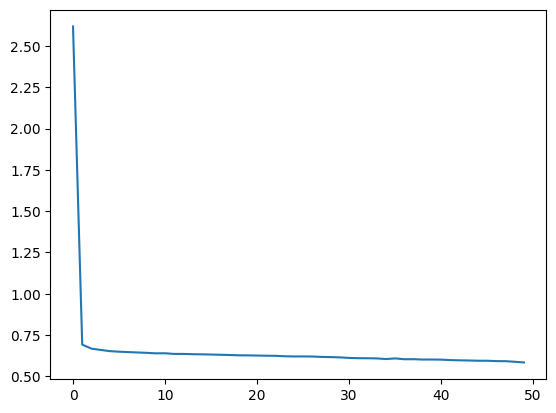

In [295]:
# Plot the Loss Curve
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history["loss"])

In [327]:
input_string = [["why", "are", "those", "people", "so", "about"]]

def convert(string):
  input_string_arr = encode(input_string)
  input_string_arr = pad_sequences(input_string_arr, maxlen=10, padding="pre", value=0)
  input_string_arr = tf.keras.utils.to_categorical(input_string_arr, num_classes=vocab_size)
  return input_string_arr

input_string_arr = convert(input_string)


y_preds = model.predict(input_string_arr)
labels = tf.argmax(y_preds, axis=2)

print([decode(input_string)[0] + [indx_to_token[int(labels[0][i])] for i in range(len(labels)) if int(labels[0][i]) != 0]])
labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[['why', 'are', 'those', 'people', 'so', 'about', 'the']]


<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[1300,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [142]:
# Evaluating the model
model.evaluate(X_test_cat, y_test_cat)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9047 - loss: 0.7137


[0.7272857427597046, 0.9033333659172058]

In [ ]:
model.save("model_0.keras")

In [ ]:
def nuke(n):
  a = []
  for i in range(10):
    if n > 1:
      a.append(nuke(n-1))
    else:
      a.append(i)
  return a

print(nuke(10))